In [1]:
import os
import wget
from pathlib import Path
# 데이터 수집 URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# 데이터셋 명
dataset_name = 'census-income'
# 데이터 저장 경로 생성
out = Path(os.getcwd() + '/data/' + dataset_name + '.csv')
out.parent.mkdir(parents = True, exist_ok = True)
if out.exists(): print("File already exists.")
else:
    print("Downloading file...")
    # 데이터 다운로드
    wget.download(url, out.as_posix())

File already exists.


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# 데이터 불러오기
train = pd.read_csv(out).copy()
target = ' <=50K'
# 학습/검증/평가 데이터 구분
if "Set" not in train.columns: train["Set"] = np.random.choice(["train", "valid", "test"], p = [.8, .1, .1], size = (train.shape[0], ))
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices  = train[train.Set == "test" ].index
# 컬럼별 unique 개수
nunique = train.nunique()
# 컬럼별 dtype
types = train.dtypes
categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    # 범주형 변수면 결측을 VV_likely로 채우고 라벨 인코딩 적용
    if types[col] == 'object' or nunique[col] < 200:
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
        print(col, train[col].nunique(), l_enc.classes_)
    # 범주형 변수 아니면 결측을 평균으로 보완
    else: train.fillna(train.loc[train_indices, col].mean(), inplace = True)

39 73 [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 90]
 State-gov 9 [' ?' ' Federal-gov' ' Local-gov' ' Never-worked' ' Private'
 ' Self-emp-inc' ' Self-emp-not-inc' ' State-gov' ' Without-pay']
 Bachelors 16 [' 10th' ' 11th' ' 12th' ' 1st-4th' ' 5th-6th' ' 7th-8th' ' 9th'
 ' Assoc-acdm' ' Assoc-voc' ' Bachelors' ' Doctorate' ' HS-grad'
 ' Masters' ' Preschool' ' Prof-school' ' Some-college']
 13 16 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 Never-married 7 [' Divorced' ' Married-AF-spouse' ' Married-civ-spouse'
 ' Married-spouse-absent' ' Never-married' ' Separated' ' Widowed']
 Adm-clerical 15 [' ?' ' Adm-clerical' ' Armed-Forces' ' Craft-repair' ' Exec-managerial'
 ' Farming-fishing' ' Handlers-cleaners' ' Machine-op-inspct'
 ' Other-service' ' Priv-house-serv' ' Prof-specialty' ' Protective-serv'
 ' Sa

In [3]:
# 타겟 라벨 변경
train.loc[train[target] == 0, target] = "not_wealthy"
train.loc[train[target] == 1, target] = "wealthy"

In [4]:
# 입력 변수
unused_feat = ['Set']
features = [col for col in train.columns if col not in unused_feat + [target]] 
# 범주형 변수
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [5]:
# 학습 데이터
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]
# 검증 데이터
X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]
# 평가 데이터
X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [9]:
import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
# TabNetPretrainer 인스턴스 생성
unsupervised_model = TabNetPretrainer(
    cat_idxs = cat_idxs,
    cat_dims = cat_dims,
    cat_emb_dim = 3,
    optimizer_fn = torch.optim.Adam,
    optimizer_params = dict(lr = 2e-2),
    mask_type = 'entmax', # "sparsemax",
    #n_shared_decoder = 1, # nb shared glu for decoding
    #n_indep_decoder = 1, # nb independent glu for decoding
    )
# 최대 epoch 설정
max_epochs = 1000 if not os.getenv("CI", False) else 2
# Pretrain 훈련(Unsupervised)
unsupervised_model.fit(
    X_train = X_train,
    eval_set = [X_valid],
    max_epochs = max_epochs , patience = 5,
    batch_size = 2048, virtual_batch_size = 128,
    num_workers = 0,
    drop_last = False,
    pretraining_ratio = 0.8,
    )

Device used : cpu
epoch 0  | loss: 3.4067  | val_0_unsup_loss: 1.71061 |  0:00:02s
epoch 1  | loss: 1.35242 | val_0_unsup_loss: 1.17858 |  0:00:05s
epoch 2  | loss: 1.14087 | val_0_unsup_loss: 1.09997 |  0:00:08s
epoch 3  | loss: 1.0984  | val_0_unsup_loss: 1.08314 |  0:00:10s
epoch 4  | loss: 1.07983 | val_0_unsup_loss: 1.06704 |  0:00:13s
epoch 5  | loss: 1.06165 | val_0_unsup_loss: 1.05446 |  0:00:15s
epoch 6  | loss: 1.05037 | val_0_unsup_loss: 1.04103 |  0:00:19s
epoch 7  | loss: 1.03374 | val_0_unsup_loss: 1.02917 |  0:00:22s
epoch 8  | loss: 1.02023 | val_0_unsup_loss: 1.00785 |  0:00:25s
epoch 9  | loss: 1.00883 | val_0_unsup_loss: 0.95785 |  0:00:27s
epoch 10 | loss: 0.99427 | val_0_unsup_loss: 0.94325 |  0:00:29s
epoch 11 | loss: 0.98314 | val_0_unsup_loss: 0.93244 |  0:00:33s
epoch 12 | loss: 0.97241 | val_0_unsup_loss: 0.931   |  0:00:35s
epoch 13 | loss: 0.9707  | val_0_unsup_loss: 0.9206  |  0:00:38s
epoch 14 | loss: 0.96426 | val_0_unsup_loss: 0.91477 |  0:00:40s
epoch 1

In [13]:
# Reconstruction 데이터 생성
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape == embedded_X.shape)
# 검증 데이터셋의 Pretrained Explain matrix와 Masks 생성
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

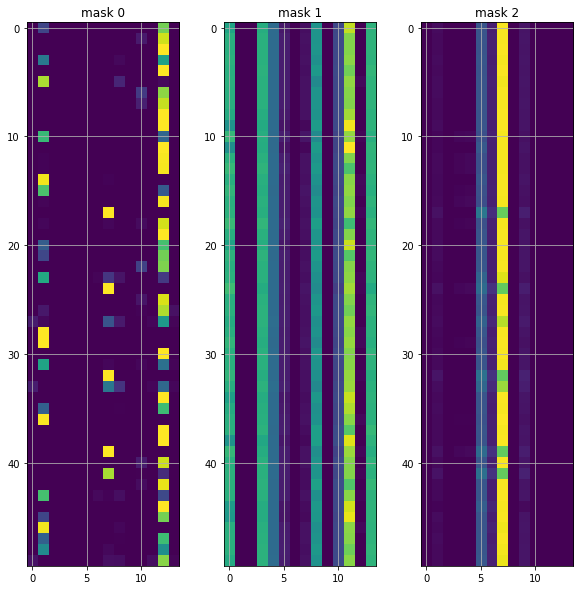

In [16]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize = (10, 10))
for i in range(3):
    axs[i].imshow(unsupervised_masks[i][: 50])
    axs[i].set_title(f"mask {i}")
    axs[i].grid()
plt.show()

In [26]:
# Pretrained 모델 저장
unsupervised_model.save_model('./example_binary_classification_pretrained')
# Pretrained 모델 불러오기
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./example_binary_classification_pretrained.zip')

Successfully saved model at ./example_binary_classification_pretrained.zip
Device used : cpu
Device used : cpu


In [19]:
from pytorch_tabnet.tab_model import TabNetClassifier
# TabNet 인스턴스 생성
clf = TabNetClassifier(optimizer_fn = torch.optim.Adam,
                       optimizer_params = dict(lr = 2e-2),
                       scheduler_params = {"step_size" : 10, # how to use learning rate scheduler
                                           "gamma" : 0.9},
                       scheduler_fn = torch.optim.lr_scheduler.StepLR,
                       mask_type = 'sparsemax' # This will be overwritten if using pretrain model
                    )
# 훈련
clf.fit(
    X_train = X_train, y_train = y_train,
    eval_set = [(X_train, y_train), (X_valid, y_valid)], eval_name = ['train', 'valid'], eval_metric = ['auc'],
    max_epochs = max_epochs , patience = 20,
    batch_size = 1024, virtual_batch_size = 128,
    num_workers = 0,
    weights = 1,
    drop_last = False,
    from_unsupervised = loaded_pretrain
    )

Device used : cpu
Loading weights from unsupervised pretraining


C:\Users\begas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pytorch_tabnet\abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]
  warnings.warn(wrn_msg)
C:\Users\begas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pytorch_tabnet\abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
C:\Users\begas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pytorch_tabnet\abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  warnings.warn(wrn_msg)
C:\Users\begas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pytorch

epoch 0  | loss: 0.50627 | train_auc: 0.83732 | valid_auc: 0.8316  |  0:00:03s
epoch 1  | loss: 0.40822 | train_auc: 0.89278 | valid_auc: 0.88841 |  0:00:06s
epoch 2  | loss: 0.37978 | train_auc: 0.90577 | valid_auc: 0.90126 |  0:00:09s
epoch 3  | loss: 0.37244 | train_auc: 0.91392 | valid_auc: 0.90876 |  0:00:12s
epoch 4  | loss: 0.35814 | train_auc: 0.92402 | valid_auc: 0.92193 |  0:00:15s
epoch 5  | loss: 0.33975 | train_auc: 0.92179 | valid_auc: 0.91556 |  0:00:19s
epoch 6  | loss: 0.33524 | train_auc: 0.92114 | valid_auc: 0.91712 |  0:00:22s
epoch 7  | loss: 0.33342 | train_auc: 0.92137 | valid_auc: 0.91879 |  0:00:25s
epoch 8  | loss: 0.32249 | train_auc: 0.91743 | valid_auc: 0.91075 |  0:00:29s
epoch 9  | loss: 0.32599 | train_auc: 0.93042 | valid_auc: 0.92214 |  0:00:32s
epoch 10 | loss: 0.32249 | train_auc: 0.92622 | valid_auc: 0.91565 |  0:00:35s
epoch 11 | loss: 0.31607 | train_auc: 0.93297 | valid_auc: 0.92427 |  0:00:39s
epoch 12 | loss: 0.31308 | train_auc: 0.93637 | vali

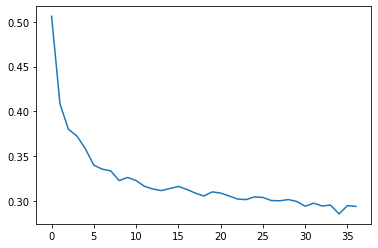

In [20]:
# loss 시각화
plt.plot(clf.history['loss'])
plt.show()

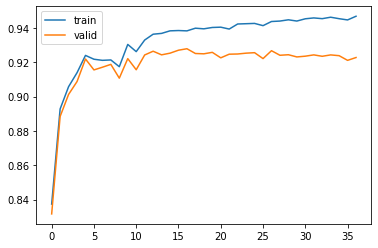

In [21]:
# AUC 시각화
plt.plot(clf.history['train_auc'], label = 'train')
plt.plot(clf.history['valid_auc'], label = 'valid')
plt.legend()
plt.show()

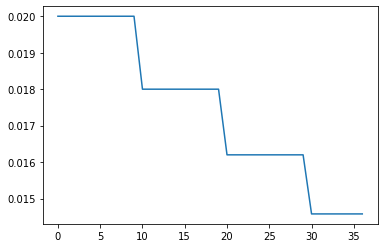

In [22]:
# 학습률 시각화
plt.plot(clf.history['lr'])
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score
# 검증 데이터 예측
preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score = preds_valid[:, 1], y_true = y_valid)
# 평가 데이터 예측
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score = preds[:, 1], y_true = y_test)
print(f"FINAL VALID SCORE FOR {dataset_name} : {valid_auc}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")
# 최적 가중치가 적용되었는지 확인
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol = 1e-6)
# 평가 데이터 예측 결과
clf.predict(X_test)

FINAL VALID SCORE FOR census-income : 0.9279042019616867
FINAL TEST SCORE FOR census-income : 0.9241715134467543


array(['wealthy', 'wealthy', 'wealthy', ..., 'not_wealthy', 'wealthy',
       'not_wealthy'], dtype='<U11')

In [28]:
# TabNet 저장
saving_path_name = "./example_binary_classification_pretrained_tabnet"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./example_binary_classification_pretrained_tabnet.zip


In [29]:
# TabNet 불러오기
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)
print(saved_filepath)

Device used : cpu
Device used : cpu
./example_binary_classification_pretrained_tabnet.zip


In [30]:
# 불러온 TabNet으로 평가 데이터 예측
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score = loaded_preds[:, 1], y_true = y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")
assert(test_auc == loaded_test_auc)
# 평가 데이터 예측 결과
loaded_clf.predict(X_test)

FINAL TEST SCORE FOR census-income : 0.9241715134467543


array(['wealthy', 'wealthy', 'wealthy', ..., 'not_wealthy', 'wealthy',
       'not_wealthy'], dtype='<U11')

In [31]:
# Global Explainability
clf.feature_importances_

array([1.12607387e-01, 7.80398177e-02, 1.06975040e-06, 7.54735418e-02,
       5.29408231e-04, 6.69395400e-02, 5.75704618e-02, 9.43804087e-02,
       1.56664835e-02, 9.55046687e-02, 1.29743959e-01, 6.52381471e-02,
       1.82309283e-01, 2.59958238e-02])

Shape of explain_matrix:  (3157, 14)
Keys of masks:  dict_keys([0, 1, 2])
Shape of masks[0]:  (3157, 14)


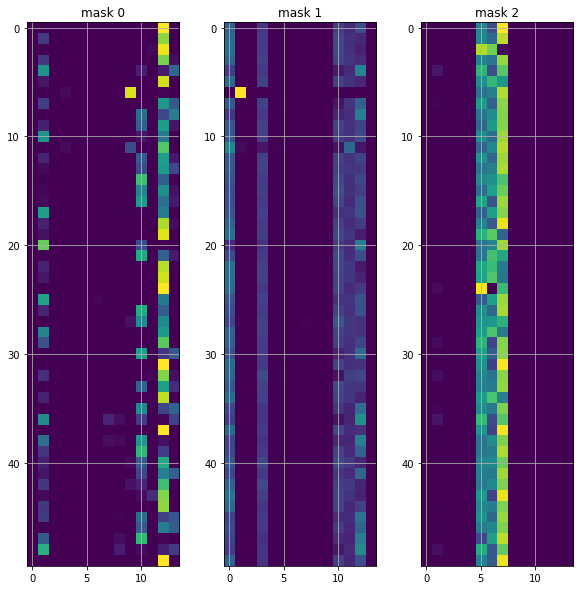

In [32]:
# Local Explainability와 Masks
explain_matrix, masks = clf.explain(X_test)
print("Shape of explain_matrix: ", explain_matrix.shape)
print("Keys of masks: ", masks.keys())
print("Shape of masks[0]: ", masks[0].shape)
# Masks 시각화
fig, axs = plt.subplots(1, 3, figsize = (10, 10))
for i in range(3):
    axs[i].imshow(masks[i][: 50])
    axs[i].set_title(f"mask {i}")
    axs[i].grid()
plt.show()